## Series Temporales - Trabajo Práctico
### Alumna: Ariadna Garmendia

### Tema: Análisis de cantidad de pasajeros que pasaron por los molinetes del subte en la Ciudad Autónoma de Buenos Aires entre 2017 y 2019.

### PRE-PROCESAMIENTO CON DIFERENTES TRANSFORMACIONES

#### BOX-COX

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
import seaborn as sns
from scipy.stats import boxcox 
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller, acf, kpss, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scripts.import_data import data

In [2]:
molinetes, _, _ = data()

In [3]:
box_cox = molinetes.copy()

In [33]:
box_cox['total0'] = boxcox(box_cox['total'], lmbda=0.0) # Transformación logarítmica
box_cox['total0.05'] = boxcox(box_cox['total'], lmbda=0.05)
box_cox['total0.1'] = boxcox(box_cox['total'], lmbda=0.1) 
box_cox['total0.5'] = boxcox(box_cox['total'], lmbda=0.5) 

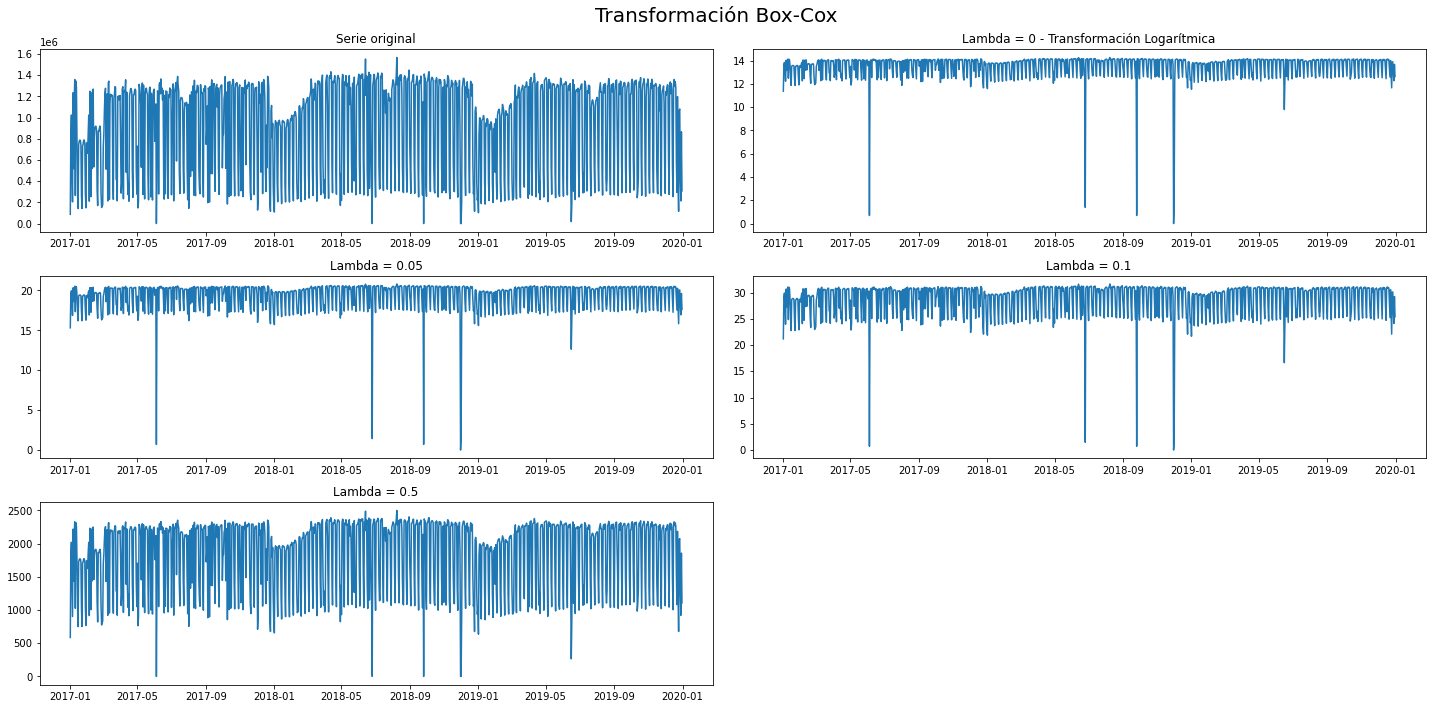

In [34]:
plt.figure(figsize=[20,10])

plt.subplot(3,2,1)
plt.plot(box_cox.total)
plt.title('Serie original')

plt.subplot(3,2,2)
plt.plot(box_cox.total0)
plt.title('Lambda = 0 - Transformación Logarítmica')

plt.subplot(3,2,3)
plt.plot(box_cox['total0.05'])
plt.title('Lambda = 0.05')


plt.subplot(3,2,4)
plt.plot(box_cox['total0.1'])
plt.title('Lambda = 0.1')

plt.subplot(3,2,5)
plt.plot(box_cox['total0.5'])
plt.title('Lambda = 0.5')

plt.suptitle('Transformación Box-Cox').set_fontsize(20)
plt.tight_layout()


#### Se ve el efecto de la transformación, para valores más pequeños de lambda se reduce el efecto en los cambios de varianza. También se observa una reducción de escala. Con la Transformación logarítmica parece que se reducen significativamente los cambios de varianza.

#### Autocorrelación de la serie transformada (con Transformación Logarítmica)

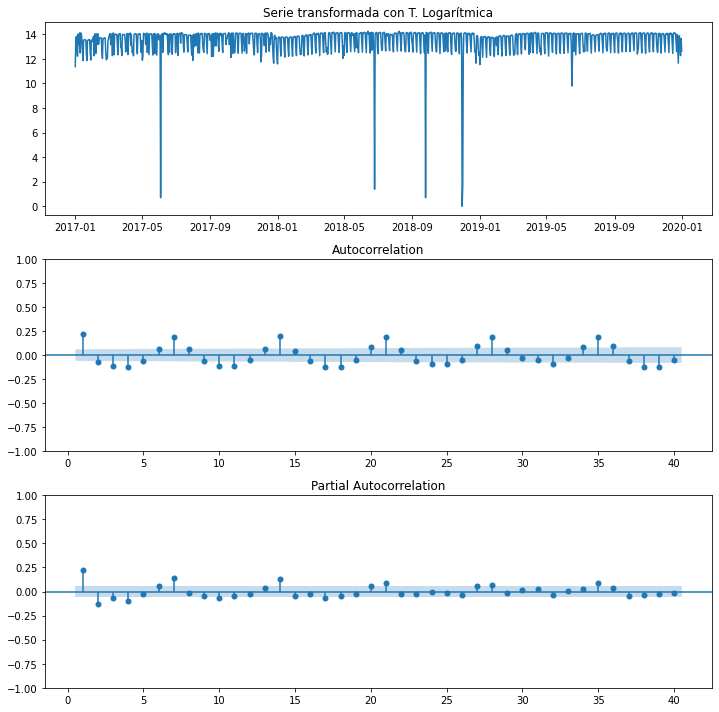

In [35]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
ax[0].plot(box_cox.total0)
ax[0].set_title('Serie transformada con T. Logarítmica')
sm.graphics.tsa.plot_acf(box_cox.total0, lags=40, ax=ax[1], zero=False)
sm.graphics.tsa.plot_pacf(box_cox.total0, method='ywm', lags=40, ax=ax[2], zero=False)
plt.tight_layout()
plt.show()

#### Luego de esta transformación se ve en la gráfica de Autocorrelación que las amplitudes para lags más grandes se reducen bastante. Se mantienen pequeñas componentes cíclicas 

#### MEDIA Y MEDIANA MÓVIL

In [36]:
rolling_mean = molinetes.copy()
rolling_median = molinetes.copy()

In [37]:
rolling_mean['result_7']=rolling_mean['total'].rolling(7).mean()
rolling_mean['result_14']=rolling_mean['total'].rolling(14).mean()
rolling_mean['result_30']=rolling_mean['total'].rolling(30).mean()
rolling_mean['result_52']=rolling_mean['total'].rolling(52).mean()

In [38]:
rolling_median['result_7']=rolling_median['total'].rolling(7).median()
rolling_median['result_14']=rolling_median['total'].rolling(14).median()
rolling_median['result_30']=rolling_median['total'].rolling(30).median()
rolling_median['result_52']=rolling_median['total'].rolling(52).median()

In [39]:
#Exporto para usarlos en otra notebook
rolling_mean.to_csv('dataset/rolling_mean.csv', index= True, index_label='fecha')
rolling_median.to_csv('dataset/rolling_median.csv', index= True, index_label='fecha')

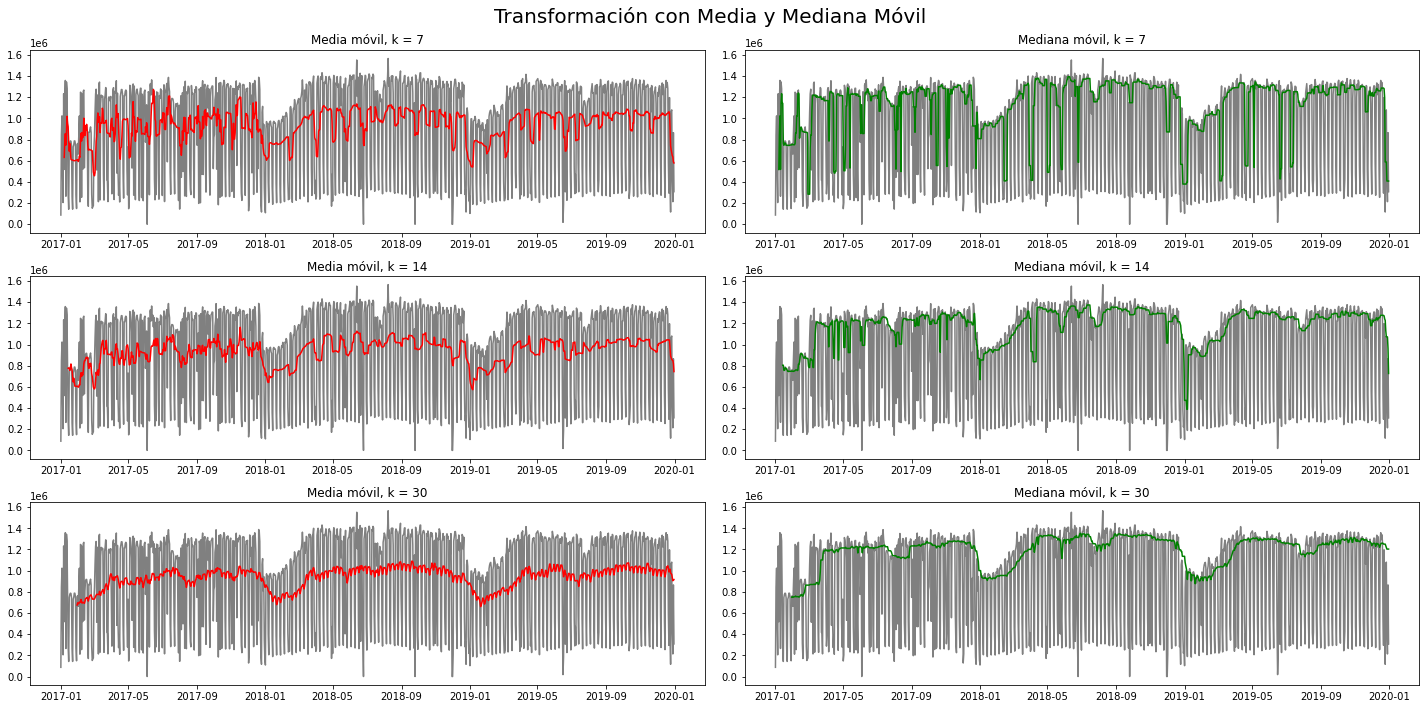

In [40]:
plt.figure(figsize=[20,10])

plt.subplot(3,2,1)
plt.plot(rolling_mean.total, color='gray')
plt.plot(rolling_mean['result_7'], color='red')
plt.title('Media móvil, k = 7')

plt.subplot(3,2,2)
plt.plot(rolling_median.total, color='gray')
plt.plot(rolling_median['result_7'], color='green')
plt.title('Mediana móvil, k = 7')

plt.subplot(3,2,3)
plt.plot(rolling_mean.total, color='gray')
plt.plot(rolling_mean['result_14'], color='red')
plt.title('Media móvil, k = 14')

plt.subplot(3,2,4)
plt.plot(rolling_median.total, color='gray')
plt.plot(rolling_median['result_14'], color='green')
plt.title('Mediana móvil, k = 14')

plt.subplot(3,2,5)
plt.plot(rolling_mean.total, color='gray')
plt.plot(rolling_mean['result_30'], color='red')
plt.title('Media móvil, k = 30')

plt.subplot(3,2,6)
plt.plot(rolling_median.total, color='gray')
plt.plot(rolling_median['result_30'], color='green')
plt.title('Mediana móvil, k = 30')

plt.suptitle('Transformación con Media y Mediana Móvil').set_fontsize(20)
plt.tight_layout()


#### Analizo cómo queda la ACF y PACF para las series suavizadas con k=30

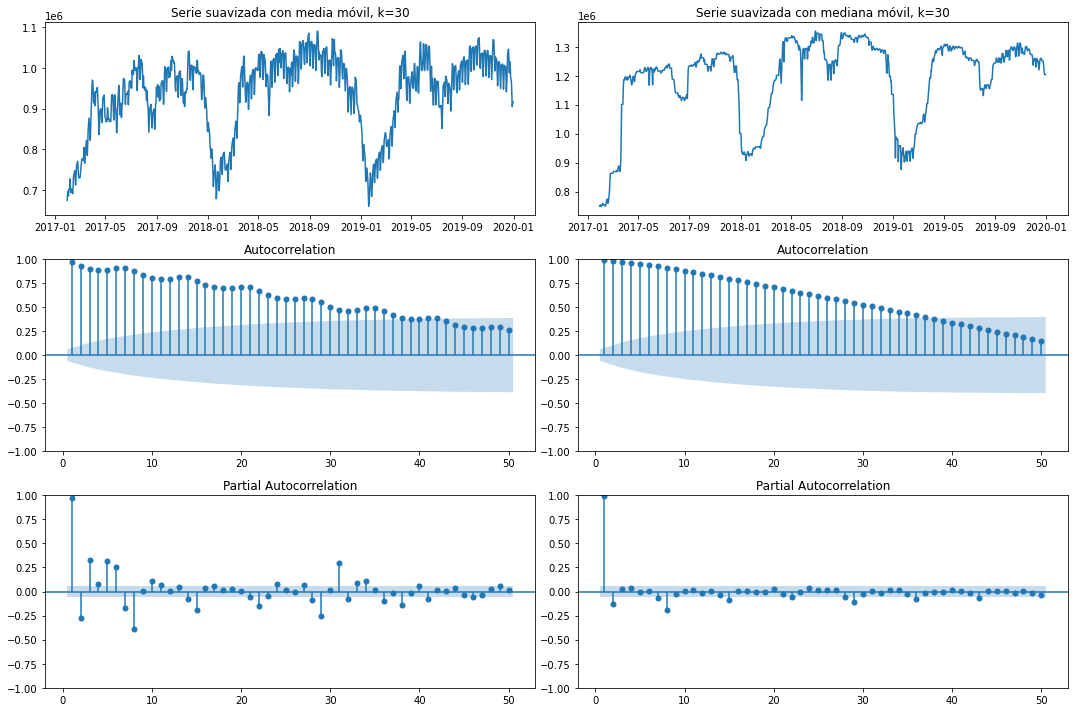

In [41]:
fig, ax = plt.subplots(3,2,figsize=(15,10))
ax[0,0].plot(rolling_mean.result_30)
ax[0,0].set_title('Serie suavizada con media móvil, k=30')
ax[0,1].plot(rolling_median.result_30)
ax[0,1].set_title('Serie suavizada con mediana móvil, k=30')
sm.graphics.tsa.plot_acf(rolling_mean.result_30[30:], ax=ax[1,0], lags=50, zero=False)
sm.graphics.tsa.plot_pacf(rolling_mean.result_30[30:], method='ywm', ax=ax[2,0], lags=50, zero=False)
sm.graphics.tsa.plot_acf(rolling_median.result_30[30:], ax=ax[1,1], lags=50, zero=False)
sm.graphics.tsa.plot_pacf(rolling_median.result_30[30:], method='ywm', ax=ax[2,1], lags=50, zero=False)
plt.tight_layout()
plt.show()

#### Aplicando suavizado con media y mediana móvil cambian bastante la ACF y PACF. Para la ACF, los valores decrecen lentamente (desaparecieron las componentes cíclicas que se veían en la serie original) y se hacen 0 alrededor del lag 38 (quedan adentro del área celeste que muestra el nivel de confianza donde se considera que las muestras valen cero). Siendo que mi serie tiene 1092 puntos, podría considerarse comportamiento estacionario.
#### La PACF muestra una componente grande en el lag 1 en ambos casos, y se ven algunas componentes cíclicas. 


### DIFERENCIACIÓN

In [43]:
difference = molinetes.copy()

In [44]:
difference['diff_1'] = difference['total'].diff()
difference['diff_7'] = difference['total'].diff(periods = 7)
difference['diff_365'] = difference['total'].diff(periods = 365)

In [45]:
#Exporto para utilizar en otra notebook
difference.to_csv('dataset/difference.csv', index= True, index_label='fecha')

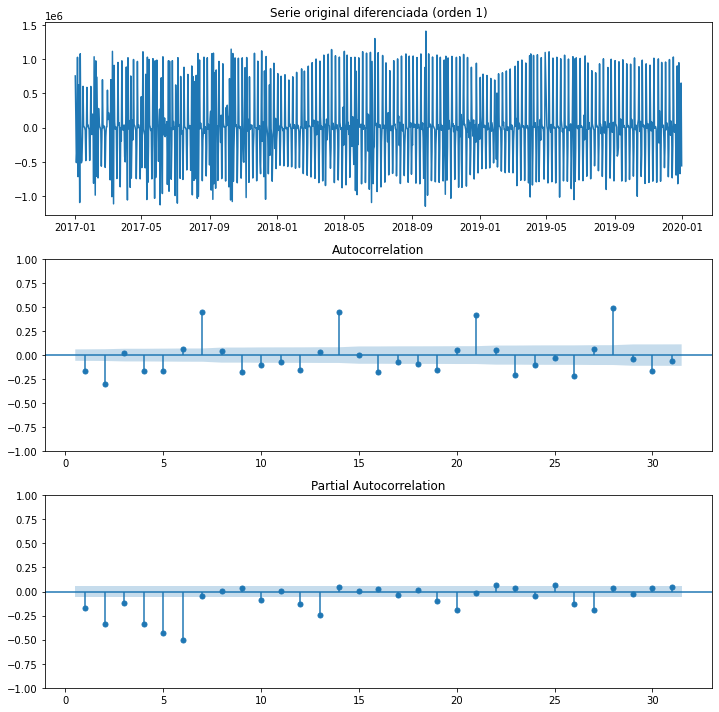

In [46]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
ax[0].plot(difference.diff_1)
ax[0].set_title('Serie original diferenciada (orden 1)')
sm.graphics.tsa.plot_acf(difference.diff_1[1:], ax=ax[1], zero=False)
sm.graphics.tsa.plot_pacf(difference.diff_1[1:], method='ywm', ax=ax[2], zero=False)
plt.tight_layout()
plt.show()

#### Con orden se reducen las aplitudes de los valores de correlación pero se mantienen las componentes cíclicas semanales (cada aprox 7 lags)

#### Hago diferenciación considerando el período semanal (a 7 pasos)

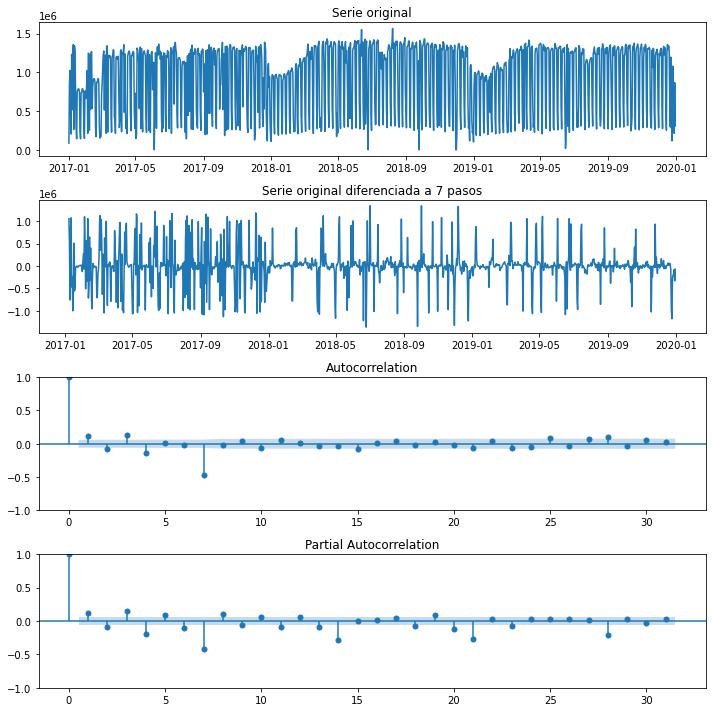

In [47]:
fig, ax = plt.subplots(4,1,figsize=(10,10))
ax[0].plot(molinetes)
ax[0].set_title('Serie original')
ax[1].plot(difference.diff_7)
ax[1].set_title('Serie original diferenciada a 7 pasos')
sm.graphics.tsa.plot_acf(difference.diff_7[7:], ax=ax[2])
sm.graphics.tsa.plot_pacf(difference.diff_7[7:], method='ywm', ax=ax[3])
plt.tight_layout()
plt.show()

#### En este caso prácticamente desaparecieron las componentes cíclicas semanales que era lo esperado

#### Me fijo qué pasaría si diferencio considerando un período anual (365) 

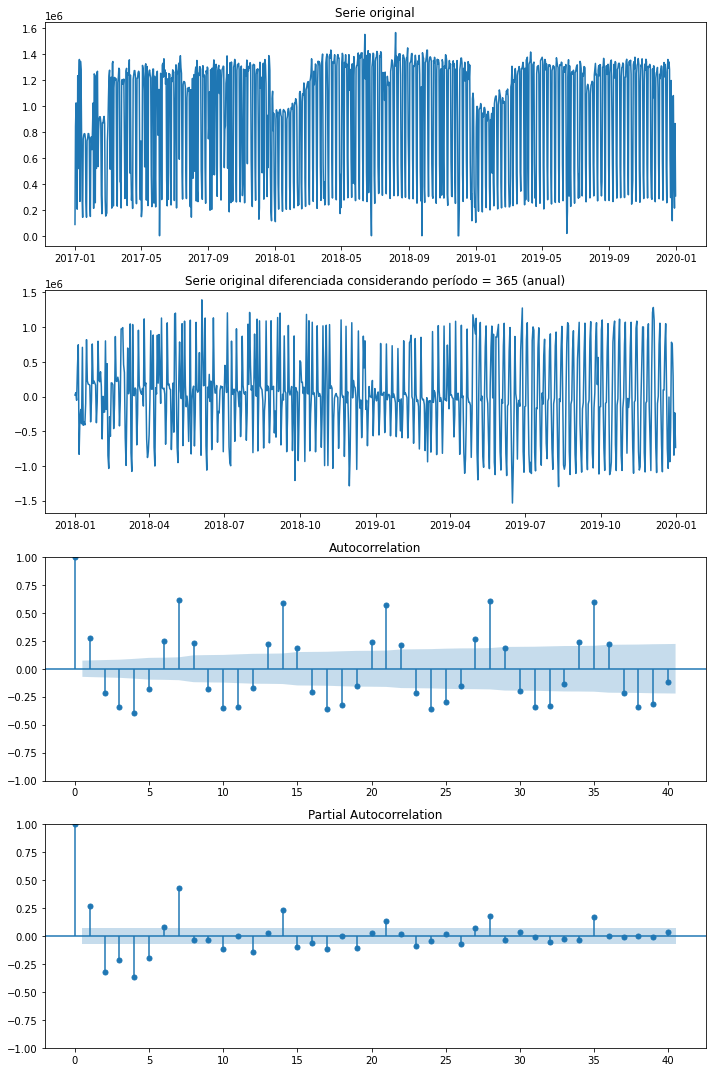

In [48]:
fig, ax = plt.subplots(4,1,figsize=(10,15))
ax[0].plot(molinetes)
ax[0].set_title('Serie original')
ax[1].plot(difference.diff_365)
ax[1].set_title('Serie original diferenciada considerando período = 365 (anual)')
sm.graphics.tsa.plot_acf(difference.diff_365[365:], lags=40, ax=ax[2])
sm.graphics.tsa.plot_pacf(difference.diff_365[365:], method='ywm', lags=40, ax=ax[3])
plt.tight_layout()
plt.show()

#### En este caso en realidad le estaría sacando a la serie la parte que me interesaba modelar, entonces no la voy a usar